In [1]:
import keras
import tensorflow as tf
import os
import numpy as np
import time
import pprint
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.copy_on_write = True

In [2]:
!pip install gymnasium
!pip install -q git+https://github.com/eleurent/highway-env
!pip install -q git+https://github.com/DLR-RM/stable-baselines3
!pip install scikit-optimize

In [3]:
import gymnasium as gym
import highway_env
from matplotlib import pyplot as plt
# %matplotlib inline
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure, Image

# Commented out IPython magic to ensure Python compatibility.
# Visualization utils
# %load_ext tensorboard
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts')
#from utils import record_videos, show_videos

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


#### Defining the __search space__ for Bayesian Optimization, and separating out ``env_config`` to change n update ``high_speed_reward``, ``right_lane_reward``, ``lane_change_reward``, and ``collision_reward``

In [4]:
# SEARCH SPACE for Bayesian Optimization
space = [
    Real(1e-5, 1e-3, name='learning_rate', prior='log-uniform'),
    Real(0.8, 0.99, name='gamma'),
    Real(0.1, 1.0, name='high_speed_reward'),
    Real(0.1, 0.5, name='right_lane_reward'),
    Real(-0.5, -0.01, name='lane_change_reward'),
    Integer(-5, -1, name='collision_reward')
]


env_config= {
            "observation": {
                "type": "Kinematics",
                "absolute": True,
                "features_range": {
                    "x": [-100, 100],
                    "y": [-100, 100],
                    "vx": [-15, 15],
                    "vy": [-15, 15],
                },
            },
            "action": {"type": "DiscreteMetaAction", "target_speeds": [0, 8, 16]},
            "incoming_vehicle_destination": None,
            "collision_reward": -2,
            "high_speed_reward": 0.6,
            "right_lane_reward": 0.2,
            "lane_change_reward": -0.1,
            "screen_width": 600,
            "screen_height": 600,
            "centering_position": [0.5, 0.6],
            "duration": 11,
            "normalize_reward": True,
        }

In [5]:
def env_create(config, seed=42):
    env = gym.make("roundabout-v0", config=config, render_mode='rgb_array')
    env.reset(seed=seed)
    return env

env = env_create(env_config)
pprint.pprint(env.unwrapped.config)

{'action': {'target_speeds': [0, 8, 16], 'type': 'DiscreteMetaAction'},
 'centering_position': [0.5, 0.6],
 'collision_reward': -2,
 'duration': 11,
 'high_speed_reward': 0.6,
 'incoming_vehicle_destination': None,
 'lane_change_reward': -0.1,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'absolute': True,
                 'features_range': {'vx': [-15, 15],
                                    'vy': [-15, 15],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'type': 'Kinematics'},
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'right_lane_reward': 0.2,
 'scaling': 5.5,
 'screen_height': 600,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15}


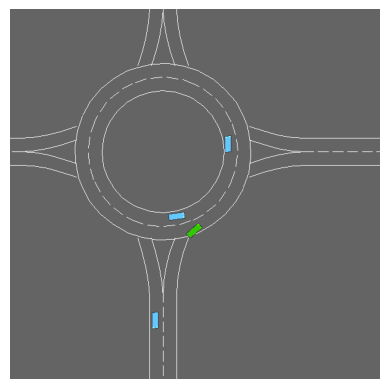

In [6]:
for _ in range(3):
    action = env.unwrapped.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
plt.axis('off')
plt.show()

In [7]:
# Objective function for Bayesian Optimization
@use_named_args(space)
def objective(learning_rate, gamma, high_speed_reward, right_lane_reward,
             lane_change_reward, collision_reward):

    # Updating environment config with current hyperparameters
    current_env_config = env_config.copy()
    current_env_config.update({
        "high_speed_reward": high_speed_reward,
        "right_lane_reward": right_lane_reward,
        "lane_change_reward": lane_change_reward,
        "collision_reward": collision_reward
    })

    # Creating environment with current config
    env = env_create(current_env_config)

    # Creating and training the model
    model = DQN('MlpPolicy', env,
                policy_kwargs=dict(net_arch=[256, 256]),
                learning_rate=learning_rate,
                buffer_size=20000,
                learning_starts=1000,
                batch_size=32,
                gamma=gamma,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=50,
                exploration_fraction=0.6,
                verbose=0,
                tensorboard_log='highway_dqn/')

    model.learn(total_timesteps=20000)


    # Evaluating the model
    n_tests = 10
    total_reward = 0

    eval_env = env_create(current_env_config)

    for _ in range(n_tests):
        done = truncated = False
        obs, info = env.reset()
        episode_reward = 0

        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = eval_env.step(action)
            episode_reward += reward

        total_reward += episode_reward

    mean_reward = total_reward / n_tests
    env.close()

    return -mean_reward #as BO return negative of res_gp.fun

### Running __Bayesian Optimization__


In [8]:
start = time.perf_counter()
res_gp = gp_minimize(
    objective,                 # Objective function to minimize
    space,                     # Hyperparameter space
    n_calls=15,                # Number of evaluations
    n_random_starts=10,        # Number of random initialization points
    random_state=42,           # Random seed
    acq_func='EI',             # Expected Improvement acquisition function
    noise=0.001,               # Adding Noise level
    n_jobs=-1,                 # Use all available CPU cores
    verbose=True               # Progress
)
end = time.perf_counter()

s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Time for Bayesian Optimization: {s2mps(end - start)}")

#printing best parameters
print("\nBest parameters:")
print("===========================\n")
print(f"{'learning_rate:':<20} {res_gp.x[0]:.6f}")
print(f"{'gamma:':<20} {res_gp.x[1]:.3f}")
print(f"{'high_speed_reward:':<20} {res_gp.x[2]:.3f}")
print(f"{'right_lane_reward:':<20} {res_gp.x[3]:.3f}")
print(f"{'lane_change_reward:':<20} {res_gp.x[4]:.3f}")
print(f"{'collision_reward:':<20} {res_gp.x[5]:.3f}")
print(f"{'Best reward:':<20} {res_gp.fun:.3f}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1098.7731
Function value obtained: -0.4195
Current minimum: -0.4195
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1070.1475
Function value obtained: -1.8564
Current minimum: -1.8564
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1265.5527
Function value obtained: -1.3126
Current minimum: -1.8564
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1129.8780
Function value obtained: -0.6103
Current minimum: -1.8564
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1102.0773
Function value obtained: -0.6182
Current minimum: -1.8564
Iteration 

### __Convergence Plot__

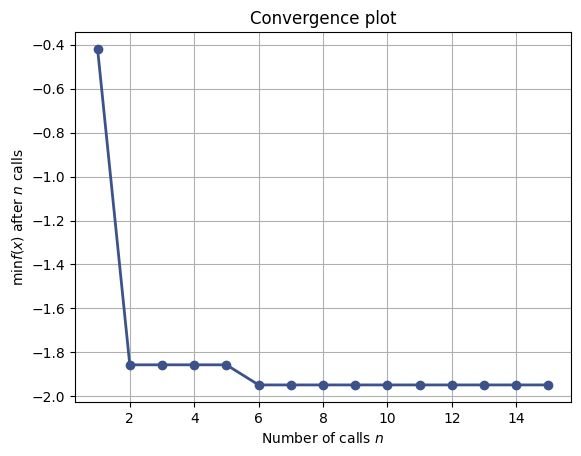

In [9]:
# Plotting convergence
plot_convergence(res_gp)
plt.show()

### __Training the Final Model__ with __Best Parameters__ found from __Bayesian Optimization__ above

In [10]:
#Training final model with best parameters
best_params = res_gp.x

#Updating environment configurations
best_env_config = env_config.copy()
best_env_config.update({
    "high_speed_reward": best_params[2],
    "right_lane_reward": best_params[3],
    "lane_change_reward": best_params[4],
    "collision_reward": best_params[5]
})

# Creating new environment with best config
env = env_create(best_env_config)

#Then training the final model
final_model = DQN('MlpPolicy', env,
                policy_kwargs=dict(net_arch=[256, 256]),
                learning_rate=best_params[0],
                buffer_size=20000,
                learning_starts=1000,
                batch_size=32,
                gamma=best_params[1],
                train_freq=1,
                gradient_steps=1,
                target_update_interval=50,
                exploration_fraction=0.6,
                verbose=1,
                tensorboard_log='highway_dqn/')


start = time.perf_counter()
final_model.learn(total_timesteps=50000)
end = time.perf_counter()

s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Time to run: {s2mps(end - start)}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to highway_dqn/DQN_18
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.5      |
|    ep_rew_mean      | 5.71     |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 21       |
|    time_elapsed     | 1        |
|    total_timesteps  | 26       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.5      |
|    ep_rew_mean      | 5.75     |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 21       |
|    time_elapsed     | 2        |
|    total_timesteps  | 52       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.75     |
|

### Calculating

1. __Average Time to Fail__,
2. __Average Distance Travelled__
3. __Average Reward Earned__



In [11]:
# Initialize lists to store results for each episode
total_failtime = []
total_distance = []
total_reward = []

simulation_frequency = 15
n_tests = 25

eval_env = env_create(best_env_config)

for ix in range(n_tests):
    timetofail = 0
    distance = 0
    sumreward = 0
    done = truncated = False

    obs, info = eval_env.reset()
    # Run the episode until termination (either done or truncated)
    while not (done or truncated):

        # Use the trained model to predict the next action deterministically and executing the action in env
        action, _states = final_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = eval_env.step(action)

        timetofail += 1
        sumreward += reward
        distance += info['speed'] / simulation_frequency

    # Append the results of this episode to the respective lists
    total_failtime.append(timetofail)
    total_distance.append(distance)
    total_reward.append(sumreward)

# Calculate and print the average results across all test episodes
print(f'Avg time to fail [s] = {np.sum(total_failtime) / n_tests / simulation_frequency:.2f}')
print(f'Avg distance traveled [m]= {np.sum(total_distance) / n_tests:.2f}')
print(f'Avg reward = {np.sum(total_reward) / n_tests:.2f}')
env.close()

Avg time to fail [s] = 0.72
Avg distance traveled [m]= 3.86
Avg reward = 9.90


In [13]:
# # Record videos with the best model
# env = env_create(best_env_config)
# env = record_videos(env)

# for episode in trange(3, desc='Test episodes'):
#     (obs, info), done = env.reset(), False
#     while not done:
#         action, _ = final_model.predict(obs, deterministic=True)
#         obs, reward, done, truncated, info = env.step(int(action))

# env.close()
# show_videos()